# Etown Women's Basketball Win Prediction

## Web Scraping (Data Collection)

In [1]:
# DO NOT RUN
raise KeyboardInterrupt()

import asyncio
from playwright.sync_api import sync_playwright
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd
from functools import reduce
from time import sleep
import random
import os

def scrape_game(url):
    # --- Step 1: Fetch fully-rendered HTML with Playwright ---
    with sync_playwright() as p:
        browser = p.chromium.launch(headless=True)  # headless browser
        page = browser.new_page()
        page.goto(url, wait_until="networkidle", timeout=120000)    # wait until JS loads tables
        html = page.content()
        browser.close()

    soup = BeautifulSoup(html, "html.parser")
    print('URL loaded successfully.')


    # --- Step 2: Extract game metadata ---
    game_details_element = soup.find("aside", class_="game-details")
    game_details = {}
    key = None
    for detail in game_details_element.dl.children:
        if detail.name is not None:
            if detail.name != 'dt':
                game_details[key] = detail.get_text(strip=True)
            else:
                key = detail.get_text(strip=True)
    game_details['Date'] = game_details['Date'].replace('/', '-')
    game_date = game_details['Date']
    
    # Get total scores and names for teams (totals are first two of six headers)
    team_names_and_scores = [h3.get_text(strip=True) for h3 in soup.find_all("h3", class_="sub-heading")][:2]
    if len(team_names_and_scores) != 2:
        raise ValueError("Could not find both team names")

    home_team, home_score = " ".join(team_names_and_scores[0].split(" ")[:-1]), team_names_and_scores[0].split(" ")[-1]
    away_team, away_score = " ".join(team_names_and_scores[1].split(" ")[:-1]), team_names_and_scores[1].split(" ")[-1]
    game_id = f"{home_team}_{away_team}_{game_date.replace(' ', '_')}"
    print(f"Game teams: {home_team} ({home_score}) vs. {away_team} ({away_score})")
    
    # --- Step 3: Extract player stats ---
    player_columns = ["##", "Player", "GS", "MIN", "FG", "3PT", "FT",
                      "ORB-DRB", "REB", "PF", "A", "TO", "BLK", "STL", "PTS"]

    all_players = []

    for idx, team in enumerate([home_team, away_team]):
        table_id = f"DataTables_Table_{idx}"
        table = soup.find("table", id=table_id)
        if not table:
            continue

        rows = table.find("tbody").find_all("tr")
        for row in rows:
            cols = [c.get_text(strip=True) for c in row.find_all(['td', 'th'])]
            if not cols or "TMTEAM" in cols[1]:
                continue

            player_data = dict(zip(player_columns, cols))
            # Remove jersey number from name
            player_data['Player'] = "".join([char for char in player_data['Player'] if not char.isdigit()])
            player_data["Team"] = team
            player_data["game_id"] = game_id
            all_players.append(player_data)

    player_df = pd.DataFrame(all_players)
    player_df.to_csv(f"player_game_stats/player_data_{game_id}.csv", index=False)

    # --- Step 4: Extract team totals ---
    totals_data = []
    for idx, team in enumerate([home_team, away_team]):
        table_id = f"DataTables_Table_{idx}"
        table = soup.find("table", id=table_id)
        rows = table.find("tfoot").find_all("tr")
        

        for row in rows:
            cols = [c.get_text(strip=True) for c in row.find_all(["td","th"])]
            if cols and cols[1] == "Totals":
                totals_dict = {
                    "game_id": game_id,
                    "Team": team,
                    "Home/Away": "home" if idx == 0 else "away",
                }
                totals_dict.update(game_details)
                for key, value in zip(player_columns[3:], cols[3:]):  # skip ##, Player, GS
                    totals_dict[key] = value
                totals_data.append(totals_dict)

    totals_df = pd.DataFrame(totals_data)
    totals_df.to_csv(f"team_game_stats/game_data_{game_id}.csv", index=False)

    print(f"Saved: player_game_stats/player_data_{game_id}.csv and team_game_stats/game_data_{game_id}.csv")

def scrape_individual_game_urls(url):
    """
    Fetches a webpage and extracts all individual game URLs from the results table.

    The function:
    - Loads the page using Playwright (so JavaScript is executed)
    - Finds the section with id="res-overal"
    - Grabs the first <table> within that section
    - Iterates through each <tr> in the <tbody>
    - Extracts the first <td> text (or hyperlink if present)
    - Returns a list of game URL strings
    """
    game_urls = []

    with sync_playwright() as p:
        browser = p.chromium.launch(headless=True)
        page = browser.new_page()
        page.goto(url, wait_until="networkidle")
        html = page.content()
        browser.close()

    soup = BeautifulSoup(html, "html.parser")

    section = soup.find("section", id="res-overall")
    if not section:
        print("Section with id='res-overall' not found.")
        return []

    table = section.find("table")
    if not table:
        print("No table found inside the section.")
        return []

    tbody = table.find("tbody")
    if not tbody:
        print("No tbody found inside the table.")
        return []

    rows = tbody.find_all("tr")
    for row in rows:
        first_td = row.find("td")
        if not first_td:
            continue

        # If there's a link in the first cell, extract href
        link_tag = first_td.find("a")
        if link_tag and link_tag.has_attr("href"):
            href = link_tag["href"]
            # Ensure full URL (handle relative links)
            if href.startswith("http"):
                game_urls.append(href)
            else:
                game_urls.append("https://landmarkconference.org/" + href)
        else:
            # fallback to text content
            game_urls.append(first_td.get_text(strip=True))

    print(f"Found {len(game_urls)} game URLs.")
    return game_urls


async def scrape_team_season(url, school, year):
    """
    Scrapes a team's season statistics table from a given URL and saves it as a CSV.
    
    Parameters:
        url (str): The page URL containing the team's seasonal stats.
        school (str): The school's name (used for filename and team column).
        year (str or int): The season year (used for filename).
    """
    print(f"\nFetching season stats for {school} ({year}) ...")

    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=False)
            context = await browser.new_context(
                user_agent="Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
            )
            page = await context.new_page()
            await page.goto(url, wait_until="networkidle", timeout=30000)
            print("stalling")
            await page.wait_for_timeout(150000)  # wait extra 5 seconds for JS to load
            html = await page.content()
            await browser.close()
    except Exception as e:
        print(f"⚠️  Could not load page for {school} {year}: {e}")
        return None

    soup = BeautifulSoup(html, "html.parser")

    # Find the single main stats table
    table = soup.find("table")
    if not table:
        print(f"⚠️  No stats table found for {school} ({year}). Skipping.")
        return None

    tbody = table.find("tbody")
    if not tbody:
        print(f"⚠️  Table has no <tbody> for {school} ({year}). Skipping.")
        return None

    rows = tbody.find_all("tr")
    if not rows:
        print(f"⚠️  No data rows found for {school} ({year}). Skipping.")
        return None

    # Define expected columns
    columns = [
        "School", "Name", "GP", "MP", "PTS", "PPG", "FGM", "FGA", "FG%", 
        "3PM", "3PA", "3P%", "FTM", "FTA", "FT%", "OREB", "DREB", 
        "REB/G", "AST", "AST/G", "STL", "BLK"
    ]

    data = []

    for row in rows:
        th = row.find("th")
        tds = row.find_all("td")

        if not th or not tds:
            continue

        player_name = th.get_text(strip=True)
        values = [td.get_text(strip=True) for td in tds]

        if len(values) != len(columns) - 2:  # sanity check for column count
            print(f"Skipping malformed row for player: {player_name}")
            continue

        # Prepend school and player name
        row_data = [school, player_name] + values
        data.append(row_data)

    # Build DataFrame
    df = pd.DataFrame(data, columns=columns)

    # Ensure directory exists
    os.makedirs("season_stats", exist_ok=True)

    # Sanitize filename
    safe_school = "".join(c for c in school if c.isalnum() or c in ('_', '-')).replace(" ", "_")
    csv_path = f"season_stats/{safe_school}_{year}_seasonal_stats.csv"

    df.to_csv(csv_path, index=False)
    print(f"✅ Saved {len(df)} players to {csv_path}")

    return df

import requests
import os
import pandas as pd
from urllib.parse import urlparse, parse_qs

import os
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

def scrape_team_season2(url, school, year):
    """
    Scrapes a team's season statistics from a Landmark Conference team page.
    Automatically parses embedded JavaScript to extract API parameters.
    Saves results into season_stats/{school}_{year}_seasonal_stats.csv
    """

    print(f"\nFetching season stats for {school} ({year}) ...")

    # Try to load the page
    try:
        resp = requests.get(url, timeout=30)
        if resp.status_code != 200:
            print(f"⚠️ Page request failed ({resp.status_code}) for {school} {year}")
            return None
    except Exception as e:
        print(f"⚠️ Could not fetch page for {school} {year}: {e}")
        return None

    soup = BeautifulSoup(resp.text, "html.parser")

    # Look for script element containing conf_stats.ashx
    script_tag = soup.find("script", string=re.compile(r"conf_stats\.ashx"))
    if not script_tag or not script_tag.string:
        print(f"⚠️ Could not find script with conf_stats.ashx for {school} {year}")
        return None

    script_text = script_tag.string

    # Extract parameters from JS
    params = {}
    for key in ["team_id", "sport", "year", "conf", "postseason"]:
        match = re.search(rf"{key}:\s*'([^']+)'", script_text)
        if match:
            params[key] = match.group(1)

    if not params.get("team_id"):
        print(f"⚠️ Could not extract team_id for {school} {year}")
        return None

    # Construct API endpoint
    api_url = (
        "https://landmarkconference.org/services/conf_stats.ashx"
        f"?method=get_team_stats"
        f"&team_id={params['team_id']}"
        f"&sport={params.get('sport', 'wbball')}"
        f"&year={params.get('year', year)}"
        f"&conf={params.get('conf', 'False')}"
        f"&postseason={params.get('postseason', 'False')}"
    )

    # Request data from API
    try:
        res = requests.get(api_url, timeout=30)
        res.raise_for_status()
        data_json = res.json()
    except Exception as e:
        print(f"⚠️ Failed to fetch JSON stats for {school} {year}: {e}")
        return None

    # Verify data
    players = data_json.get("players") or data_json.get("aaData")
    if not players:
        print(f"⚠️ No player data returned for {school} {year}")
        return None

    # Define columns
    columns = [
        "School", "Name", "GP", "MP", "PTS", "PPG", "FGM", "FGA", "FG%", 
        "3PM", "3PA", "3P%", "FTM", "FTA", "FT%", "OREB", "DREB", 
        "REB/G", "AST", "AST/G", "STL", "BLK"
    ]

    # Parse player data
    data_rows = []
    for player in players:
        # Each player has stats in nested dicts like player["stats_stats"]
        stats = player.get("stats_stats", {})
        name = player.get("name", "").strip()
        row = [
            school,
            name,
            stats.get("games_played", ""),
            stats.get("minutes_played", ""),
            stats.get("points", ""),
            stats.get("points_per_game", ""),
            stats.get("field_goals_made", ""),
            stats.get("field_goals_attempted", ""),
            stats.get("field_goal_percentage", ""),
            stats.get("three_point_made", ""),
            stats.get("three_point_attempted", ""),
            stats.get("three_point_percentage", ""),
            stats.get("free_throws_made", ""),
            stats.get("free_throws_attempted", ""),
            stats.get("free_throw_percentage", ""),
            stats.get("offensive_rebounds", ""),
            stats.get("defensive_rebounds", ""),
            stats.get("rebounds_per_game", ""),
            stats.get("assists", ""),
            stats.get("assists_per_game", ""),
            stats.get("steals", ""),
            stats.get("blocks", "")
        ]
        data_rows.append(row)

    # Save to CSV
    os.makedirs("season_stats", exist_ok=True)
    safe_school = "".join(c for c in school if c.isalnum() or c in ('_', '-')).replace(" ", "_")
    csv_path = f"season_stats/{safe_school}_{year}_seasonal_stats.csv"
    df = pd.DataFrame(data_rows, columns=columns)
    df.to_csv(csv_path, index=False)

    print(f"✅ Saved {len(df)} player stats to {csv_path}")
    return df


# Example usage
if __name__ == "__main__":
    
    # Example: scrape all game URLs from the team results page
    # year = 2020
    # for year in range(2020, 2025):
    for year in range(2022, 2025):
    
        schedule_url = f"https://landmarkconference.org/stats.aspx?path=wbball&year={year}"
        game_links = scrape_individual_game_urls(schedule_url)
        # print(game_links)

        # # Optionally scrape each game found
        for link in game_links:
            scrape_game(link)
            sleep(0.15+random.randint(1, 20))
            
            print("Downloaded game.")
        print(f"Completed scraping for year {year}.")



KeyboardInterrupt: 

## Data loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import warnings # hides warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import os

player_data_list = []
team_data_list = []

directory = "./player_game_stats/"
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        player_data_list.append(df)
print(f"Loaded {len(player_data_list)} player data csv files.")

directory = "./team_game_stats/"
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        team_data_list.append(df)
print(f"Loaded {len(team_data_list)} team data csv files.")


Loaded 651 player data csv files.
Loaded 651 team data csv files.


In [3]:
player_stats = pd.concat(player_data_list, axis=0)
team_stats = pd.concat(team_data_list, axis=0)

In [4]:
display(player_stats.shape)
display(player_stats.head())
display(player_stats.info())
display(player_stats.describe())
display(player_stats.isnull().sum())

(14864, 17)

,##,Player,GS,MIN,FG,3PT,FT,ORB-DRB,REB,PF,A,TO,BLK,STL,PTS,Team,game_id
0,12,"Boggs,Gabby",*,40,8-14,0-0,7-9,5-10,15,2,4,3,4,1,23,Albright College,Albright College_Moravian University_11-9-2022
1,24,"Rauf,Amina",*,36,3-12,0-3,5-8,1-3,4,2,1,1,0,0,11,Albright College,Albright College_Moravian University_11-9-2022
2,22,"Edmond,Orianna",*,24,3-6,0-0,5-6,4-2,6,2,0,3,0,1,11,Albright College,Albright College_Moravian University_11-9-2022
3,1,"Dover,Mackenzie",*,36,2-11,1-4,2-2,3-5,8,2,5,5,0,0,7,Albright College,Albright College_Moravian University_11-9-2022
4,3,"Williamson,Lindsey",*,25,1-8,1-2,0-0,1-1,2,0,2,1,0,0,3,Albright College,Albright College_Moravian University_11-9-2022


<class 'pandas.core.frame.DataFrame'>
Index: 14864 entries, 0 to 21
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ##       14864 non-null  object
 1   Player   14864 non-null  object
 2   GS       6510 non-null   object
 3   MIN      14864 non-null  object
 4   FG       14864 non-null  object
 5   3PT      14864 non-null  object
 6   FT       14864 non-null  object
 7   ORB-DRB  14864 non-null  object
 8   REB      14864 non-null  int64 
 9   PF       14864 non-null  int64 
 10  A        14864 non-null  int64 
 11  TO       14864 non-null  int64 
 12  BLK      14864 non-null  int64 
 13  STL      14864 non-null  int64 
 14  PTS      14864 non-null  int64 
 15  Team     14864 non-null  object
 16  game_id  14864 non-null  object
dtypes: int64(7), object(10)
memory usage: 2.0+ MB


None

,REB,PF,A,TO,BLK,STL,PTS
count,14864.000000,14864.000000,14864.000000,14864.000000,14864.000000,14864.000000,14864.000000
mean,3.169537,1.439316,1.137043,1.512244,0.296757,0.803821,5.472215
std,3.059380,1.342840,1.480635,1.663993,0.690377,1.142005,5.822861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000
75%,5.000000,2.000000,2.000000,2.000000,0.000000,1.000000,8.000000
max,23.000000,6.000000,15.000000,21.000000,10.000000,10.000000,43.000000


##            0
Player        0
GS         8354
MIN           0
FG            0
3PT           0
FT            0
ORB-DRB       0
REB           0
PF            0
A             0
TO            0
BLK           0
STL           0
PTS           0
Team          0
game_id       0
dtype: int64

In [5]:
display(team_stats.shape)
display(team_stats.head())
display(team_stats.info())
display(team_stats.describe())
display(team_stats.isnull().sum())

(1302, 20)

,game_id,Team,Home/Away,Date,Attendance,Site,Referees,MIN,FG,3PT,FT,ORB-DRB,REB,PF,A,TO,BLK,STL,PTS,Notes
0,Albright College_Moravian University_11-9-2022,Albright College,home,11-9-2022,317.0,Johnston Hall,"Sharvez Brown, Bobby Hoppe, Stacey Smalls",200,20-59,2-11,22-31,21-30,51,12,12,17,5,3,64,NaN
1,Albright College_Moravian University_11-9-2022,Moravian University,away,11-9-2022,317.0,Johnston Hall,"Sharvez Brown, Bobby Hoppe, Stacey Smalls",200,29-70,4-9,4-8,13-23,36,24,17,11,7,6,66,NaN
0,Albright_Goucher_11-11-2023,Albright,home,11-11-2023,158.0,"Decker Sports & Recreation Center, Towson, MD","Samantha Jackson, Amanda Censullo-Mioni, Ronal...",200,33-83,6-18,13-21,29-31,60,15,20,21,2,13,85,NaN
1,Albright_Goucher_11-11-2023,Goucher,away,11-11-2023,158.0,"Decker Sports & Recreation Center, Towson, MD","Samantha Jackson, Amanda Censullo-Mioni, Ronal...",200,18-53,7-20,6-14,7-28,35,22,8,32,1,9,49,NaN
0,Albright_Moravian_11-15-2024,Albright,home,11-15-2024,135.0,"Johnston Hall, Bethlehem, PA","Brian Callahan, Morgan Faust, Barry Vaughn",200,26-56,4-9,11-17,13-26,39,16,11,20,6,6,67,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 0 to 1
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   game_id     1302 non-null   object 
 1   Team        1302 non-null   object 
 2   Home/Away   1302 non-null   object 
 3   Date        1302 non-null   object 
 4   Attendance  1220 non-null   float64
 5   Site        1302 non-null   object 
 6   Referees    742 non-null    object 
 7   MIN         1302 non-null   int64  
 8   FG          1302 non-null   object 
 9   3PT         1302 non-null   object 
 10  FT          1302 non-null   object 
 11  ORB-DRB     1302 non-null   object 
 12  REB         1302 non-null   int64  
 13  PF          1302 non-null   int64  
 14  A           1302 non-null   int64  
 15  TO          1302 non-null   int64  
 16  BLK         1302 non-null   int64  
 17  STL         1302 non-null   int64  
 18  PTS         1302 non-null   int64  
 19  Notes       172 non-null    object 

None

,Attendance,MIN,REB,PF,A,TO,BLK,STL,PTS
count,1220.000000,1302.000000,1302.000000,1302.00000,1302.000000,1302.000000,1302.000000,1302.000000,1302.00000
mean,207.214754,200.917051,40.507680,16.43318,12.980799,17.788018,3.387865,9.176651,62.47235
std,152.577413,5.776855,8.988738,4.79284,5.400951,6.565784,2.346458,4.790890,15.97660
min,7.000000,150.000000,15.000000,5.00000,1.000000,4.000000,0.000000,0.000000,14.00000
25%,112.000000,200.000000,35.000000,13.00000,9.000000,13.000000,2.000000,6.000000,52.00000
50%,168.500000,200.000000,40.000000,16.00000,12.000000,17.000000,3.000000,8.000000,62.00000
75%,244.000000,200.000000,46.000000,20.00000,16.000000,21.000000,5.000000,11.000000,73.00000
max,1345.000000,250.000000,79.000000,36.00000,34.000000,59.000000,12.000000,42.000000,135.00000


game_id          0
Team             0
Home/Away        0
Date             0
Attendance      82
Site             0
Referees       560
MIN              0
FG               0
3PT              0
FT               0
ORB-DRB          0
REB              0
PF               0
A                0
TO               0
BLK              0
STL              0
PTS              0
Notes         1130
dtype: int64

## Data Cleaning

In [6]:
player_stats.drop(columns=['GS'], inplace=True)
team_stats.drop(columns=['Attendance','Referees','Notes'], inplace=True) # Null columns


### Clean & standardize Player names

In [7]:
display(player_stats['Player'].nunique())

def reformatted_names_mask(name):
    name = name.strip()
    if ',' in name:
        l_f_names = [n.strip() for n in name.split(',')]
        name = l_f_names[1]+' '+l_f_names[0]
    return name

player_stats['Player'] = player_stats['Player'].apply(reformatted_names_mask)
player_stats['Player'].apply(reformatted_names_mask).nunique()

3169

2409

In [8]:
print('Player Stats')
display(player_stats.isnull().sum())
print('Team Stats')
display(team_stats.isnull().sum())

Player Stats


##         0
Player     0
MIN        0
FG         0
3PT        0
FT         0
ORB-DRB    0
REB        0
PF         0
A          0
TO         0
BLK        0
STL        0
PTS        0
Team       0
game_id    0
dtype: int64

Team Stats


game_id      0
Team         0
Home/Away    0
Date         0
Site         0
MIN          0
FG           0
3PT          0
FT           0
ORB-DRB      0
REB          0
PF           0
A            0
TO           0
BLK          0
STL          0
PTS          0
dtype: int64

### Clean and Standardize Team Names

In [9]:
print(team_stats['Team'].nunique())
print(player_stats['Team'].nunique())

169
169


In [10]:
team_stats['Team'].head(6)

0       Albright College
1    Moravian University
0               Albright
1                Goucher
0               Albright
1               Moravian
Name: Team, dtype: object

In [11]:
team_mapping = {
    'Albright College': 'albright',
    'Moravian University': 'moravian',
    'Albright': 'albright',
    'Goucher': 'goucher',
    'Moravian': 'moravian',
    'Scranton': 'scranton',
    'Wilkes': 'wilkes',
    'Alvernia': 'alvernia',
    'Elizabethtown': 'elizabethtown',
    'Juniata': 'juniata',
    'Arcadia': 'arcadia',
    'Babson': 'babson',
    'Bates': 'bates',
    'Bethany': 'bethany',
    'Bethel (Minn.)': 'bethel (minn)',
    'Brooklyn': 'brooklyn',
    'Drew': 'drew',
    'Bryn Mawr': 'bryn mawr',
    'Cabrini': 'cabrini',
    'Capital': 'capital',
    'Catholic': 'catholic',
    'Bridgewater (VA)': 'bridgewater (va)',
    'Eastern': 'eastern',
    'Gallaudet': 'gallaudet',
    'Ithaca': 'ithaca',
    'Lycoming': 'lycoming',
    'Marymount (VA)': 'marymount (va)',
    'McDaniel': 'mcdaniel',
    'Randolph-Macon': 'randolph-macon',
    'Salisbury': 'salisbury',
    "St. Mary's (MD)": 'st marys (md)',
    'Susquehanna': 'susquehanna',
    'Trinity Washington': 'trinity washington',
    'Vassar': 'vassar',
    'York (Pa.)': 'york',
    'CCNY': 'ccny',
    'Chatham': 'chatham',
    'Chris. Newport': 'chris newport',
    'Clarks Summit': 'clarks summit',
    'Colorado Col.': 'colorado col',
    'Cortland': 'cortland',
    'Delaware Valley': 'delaware valley',
    'DeSales': 'desales',
    'Dickinson': 'dickinson',
    'Drew University': 'drew',
    'FDU-Florham': 'fdu-florham',
    'JOHNJAYW': 'john jay',
    'DREW': 'drew',
    "Juniata Women's Basketball": 'juniata',
    'Kean': 'kean',
    'Medgar Evers College': 'medgar evers',
    'Rhodes': 'rhodes',
    'Rutgers University-Camden': 'rutgers-camden',
    'Wm. Paterson': 'wm paterson',
    'Yeshiva': 'yeshiva',
    'East Texas Baptist': 'east texas baptist',
    'Elizabethtown College': 'elizabethtown',
    'Franklin & Marshall': 'franklin and marshall',
    'John Carroll': 'john carroll',
    "King's (PA)": 'kings (pa)',
    'Lebanon Valley': 'lebanon valley',
    'Roanoke': 'roanoke',
    'Rowan': 'rowan',
    'Stevenson': 'stevenson',
    'Framingham St.': 'framingham st',
    'George Fox': 'george fox',
    'Goucher College': 'goucher',
    'Alfred': 'alfred',
    'Hunter': 'hunter',
    'Neumann': 'neumann',
    'Notre Dame (MD)': 'notre dame (md)',
    'Penn St.-Berks': 'penn state-berks',
    'Shenandoah': 'shenandoah',
    'Trinity (D.C.)': 'trinity (dc)',
    'Gwynedd Mercy Univ.': 'gwynedd mercy',
    'Gwynedd Mercy': 'gwynedd mercy',
    'Haverford': 'haverford',
    'Hiram': 'hiram',
    'Immaculata University': 'immaculata',
    'Immaculata': 'immaculata',
    'John Jay': 'john jay',
    'Johns Hopkins': 'johns hopkins',
    'Juniata College': 'juniata',
    'Moravian College': 'moravian',
    'Bethany (WV)': 'bethany (wv)',
    'Elmira': 'elmira',
    'Grove City': 'grove city',
    'Hood': 'hood',
    'Lehman': 'lehman',
    'Marywood': 'marywood',
    'Misericordia': 'misericordia',
    'Penn State-Harrisburg': 'penn state-harrisburg',
    'Pitt.-Bradford': 'pitt-bradford',
    'Saint Vincent': 'st vincent',
    'Wash. & Lee': 'wash and lee',
    'Keystone': 'keystone',
    "King's (Pa.)": 'kings (pa)',
    'Lancaster Bible': 'lancaster bible',
    'Lebanon Valley College': 'lebanon valley',
    'Loras': 'loras',
    'Bryn Athyn': 'bryn athyn',
    'LeTourneau': 'letourneau',
    'Nazareth': 'nazareth',
    'Penn College': 'penn college',
    'Penn St.-Altoona': 'penn state-altoona',
    'LYCOW': 'lycoming',
    'Lynchburg': 'lynchburg',
    'Mary Washington': 'mary washington',
    'Maryville (TN)': 'maryville (tn)',
    'Messiah': 'messiah',
    'Montclair St.': 'montclair st',
    'Lebanon Valley Col.': 'lebanon valley',
    'Muhlenberg College': 'muhlenberg',
    'Susquehanna University': 'susquehanna',
    'TCNJ': 'tcnj',
    'York (Pa.) College': 'york',
    'Emmanuel (MA)': 'emmanuel (ma)',
    'MORAVIAN': 'moravian',
    'Muhlenberg': 'muhlenberg',
    'Russell Sage College': 'russell sage',
    'Mount Aloysius': 'mount aloysius',
    'Mt. St. Mary (NY)': 'mt st mary (ny)',
    'Muskingum': 'muskingum',
    'New Jersey City': 'new jersey city',
    'Oberlin': 'oberlin',
    'Ohio Northern': 'ohio northern',
    'Ohio Wesleyan': 'ohio wesleyan',
    'Penn St.-Behrend': 'penn state-behrend',
    'Penn St.-Lehigh Val.': 'penn state-lehigh val',
    'Penn State-Altoona': 'penn state-altoona',
    'PSHW': 'penn state-harrisburg',
    'Raritan Valley CC': 'raritan valley',
    'Raritan Valley': 'raritan valley',
    'Rhode Island Col.': 'rhode island col',
    'RIT': 'rit',
    'Rosemont': 'rosemont',
    'Russell Sage': 'russell sage',
    'Rutgers-Camden': 'rutgers-camden',
    'Saint Elizabeth': 'st elizabeth',
    'Colby': 'colby',
    'NYU': 'nyu',
    'Stevens': 'stevens',
    'Tufts': 'tufts',
    'Wartburg': 'wartburg',
    'St. Joseph (Conn.)': 'st joseph (conn)',
    "St. Joseph's (Brkln)": 'st josephs (brkln)',
    "St. Joseph's (ME)": 'st josephs (me)',
    'St. Vincent': 'st vincent',
    'Stevens Institute': 'stevens',
    'Stockton': 'stockton',
    'SUNY Brockport': 'suny brockport',
    'SUNY Geneseo': 'suny geneseo',
    'Concordia Wisconsin': 'concordia wisconsin',
    'Gettysburg': 'gettysburg',
    'St. John Fisher': 'st john fisher',
    'Wittenberg': 'wittenberg',
    'WPI': 'wpi',
    'Univ. of Scranton': 'scranton',
    'University of Scranton': 'scranton',
    'Ursinus': 'ursinus',
    'Valley Forge': 'valley forge',
    'Wesleyan (CT)': 'wesleyan (ct)',
    'Western New Eng.': 'western new eng',
    'Widener': 'widener',
    'Wilson': 'wilson',
    'Wis.-Stout': 'wis-stout',
    'Wis.-Whitewater': 'wis-whitewater',
    'Wittenberg Univ.': 'wittenberg',
    'York (PA)': 'york',
}


In [12]:
team_stats['Team'] = team_stats['Team'].apply(lambda team: team_mapping[team])
player_stats['Team'] = player_stats['Team'].apply(lambda team: team_mapping[team])
print(team_stats['Team'].nunique())
print(player_stats['Team'].nunique())

138
138


### Extract data from String columns

In [13]:
team_stats['FG%'] = team_stats['FG'].apply(lambda x: int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1])!=0 else 0)
team_stats['3PT%'] = team_stats['3PT'].apply(lambda x: int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1])!=0 else 0)
team_stats['FT%'] = team_stats['FT'].apply(lambda x: int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1])!=0 else 0)
team_stats['ORB'] = team_stats['ORB-DRB'].apply(lambda x: int(x.split('-')[0]))
team_stats['DRB'] = team_stats['ORB-DRB'].apply(lambda x: int(x.split('-')[1]))

team_stats.drop(columns=['FG', '3PT', 'FT', 'ORB-DRB'], inplace=True)

In [14]:
player_stats['FG%'] = player_stats['FG'].apply(lambda x: int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1])!=0 else 0)
player_stats['3PT%'] = player_stats['3PT'].apply(lambda x: int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1])!=0 else 0)
player_stats['FT%'] = player_stats['FT'].apply(lambda x: int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1])!=0 else 0)
player_stats['ORB'] = player_stats['ORB-DRB'].apply(lambda x: int(x.split('-')[0]))
player_stats['DRB'] = player_stats['ORB-DRB'].apply(lambda x: int(x.split('-')[1]))

player_stats.drop(columns=['FG', '3PT', 'FT', 'ORB-DRB'], inplace=True)

### Create wins column with team match data

In [15]:
maxes = team_stats.reset_index().groupby(by='game_id')['PTS'].idxmax() # get indexes of winning matchups

l = np.arange(team_stats.shape[0])
wins_mask = [val in maxes.values for val in l] # create boolean list of whether the game is a winner
team_stats['is_win'] = wins_mask

team_stats.head()

,game_id,Team,Home/Away,Date,Site,MIN,REB,PF,A,TO,BLK,STL,PTS,FG%,3PT%,FT%,ORB,DRB,is_win
0,Albright College_Moravian University_11-9-2022,albright,home,11-9-2022,Johnston Hall,200,51,12,12,17,5,3,64,0.338983,0.181818,0.709677,21,30,False
1,Albright College_Moravian University_11-9-2022,moravian,away,11-9-2022,Johnston Hall,200,36,24,17,11,7,6,66,0.414286,0.444444,0.500000,13,23,True
0,Albright_Goucher_11-11-2023,albright,home,11-11-2023,"Decker Sports & Recreation Center, Towson, MD",200,60,15,20,21,2,13,85,0.397590,0.333333,0.619048,29,31,True
1,Albright_Goucher_11-11-2023,goucher,away,11-11-2023,"Decker Sports & Recreation Center, Towson, MD",200,35,22,8,32,1,9,49,0.339623,0.350000,0.428571,7,28,False
0,Albright_Moravian_11-15-2024,albright,home,11-15-2024,"Johnston Hall, Bethlehem, PA",200,39,16,11,20,6,6,67,0.464286,0.444444,0.647059,13,26,True


In [16]:
player_stats['is_win'] = player_stats.apply(lambda series: bool(team_stats[(team_stats['game_id']==series.loc['game_id'])&(team_stats['Team']==series.loc['Team'])]['is_win'].iloc[0]), axis=1)

In [17]:
player_stats.head(10)

,##,Player,MIN,REB,PF,A,TO,BLK,STL,PTS,Team,game_id,FG%,3PT%,FT%,ORB,DRB,is_win
0,12,Gabby Boggs,40,15,2,4,3,4,1,23,albright,Albright College_Moravian University_11-9-2022,0.571429,0.00,0.777778,5,10,False
1,24,Amina Rauf,36,4,2,1,1,0,0,11,albright,Albright College_Moravian University_11-9-2022,0.250000,0.00,0.625000,1,3,False
2,22,Orianna Edmond,24,6,2,0,3,0,1,11,albright,Albright College_Moravian University_11-9-2022,0.500000,0.00,0.833333,4,2,False
3,1,Mackenzie Dover,36,8,2,5,5,0,0,7,albright,Albright College_Moravian University_11-9-2022,0.181818,0.25,1.000000,3,5,False
4,3,Lindsey Williamson,25,2,0,2,1,0,0,3,albright,Albright College_Moravian University_11-9-2022,0.125000,0.50,0.000000,1,1,False
5,5,Amy Jones,10,1,1,0,0,0,0,5,albright,Albright College_Moravian University_11-9-2022,0.500000,0.00,0.500000,1,0,False
6,23,Julia Zakovitch,16,4,3,0,0,1,1,3,albright,Albright College_Moravian University_11-9-2022,0.500000,0.00,0.500000,1,3,False
7,13,Crisanta Apistar,11,2,0,0,1,0,0,1,albright,Albright College_Moravian University_11-9-2022,0.000000,0.00,0.500000,2,0,False
8,33,Lauren Pool,2,0,0,0,1,0,0,0,albright,Albright College_Moravian University_11-9-2022,0.000000,0.00,0.000000,0,0,False
9,20,Tessa Zamolyi,22,10,4,3,0,0,0,19,moravian,Albright College_Moravian University_11-9-2022,0.562500,0.50,0.000000,5,5,True


## EDA (Exploratory Data Analysis)

In [18]:
conference_teams = ['goucher',
'scranton',
'elizabethtown',
'catholic',
'susquehanna',
'juniata',
'drew',
'moravian',
'lycoming',
'wilkes']

<Axes: xlabel='is_win', ylabel='count'>

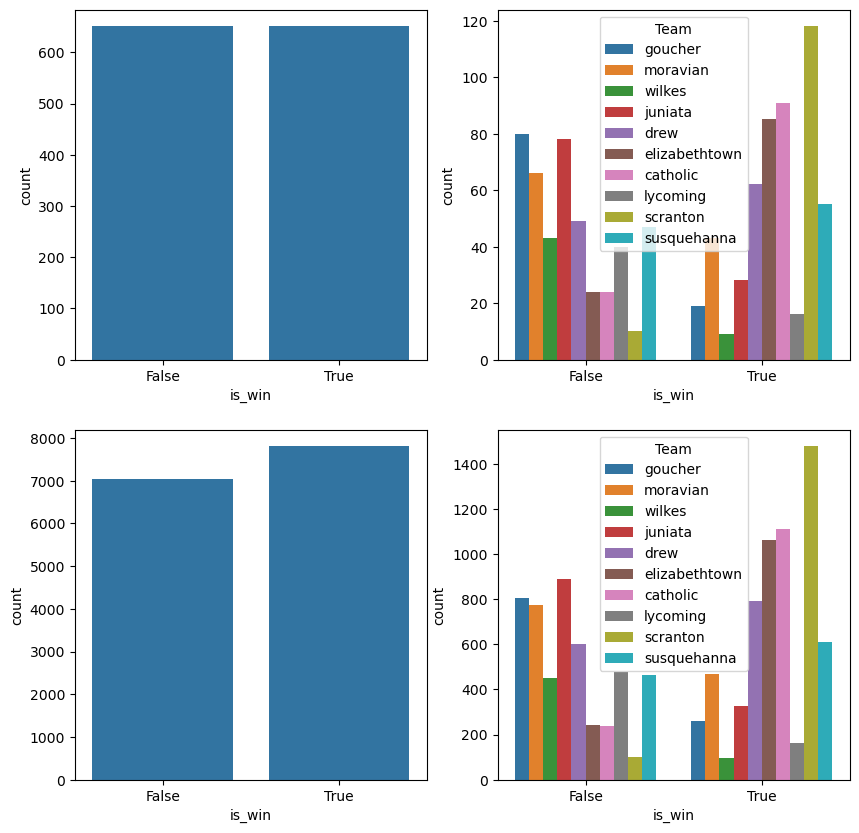

In [19]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))

sns.countplot(data=team_stats, x='is_win', ax=axes[0][0])
sns.countplot(data=team_stats[team_stats['Team'].apply(lambda team: team in conference_teams)], x='is_win', hue='Team', ax=axes[0][1])
sns.countplot(data=player_stats, x='is_win', ax=axes[1][0])
sns.countplot(data=player_stats[player_stats['Team'].apply(lambda team: team in conference_teams)], x='is_win', hue='Team', ax=axes[1][1])

##### There is clearly more games recorded with teams that are within conference vs out of conference.

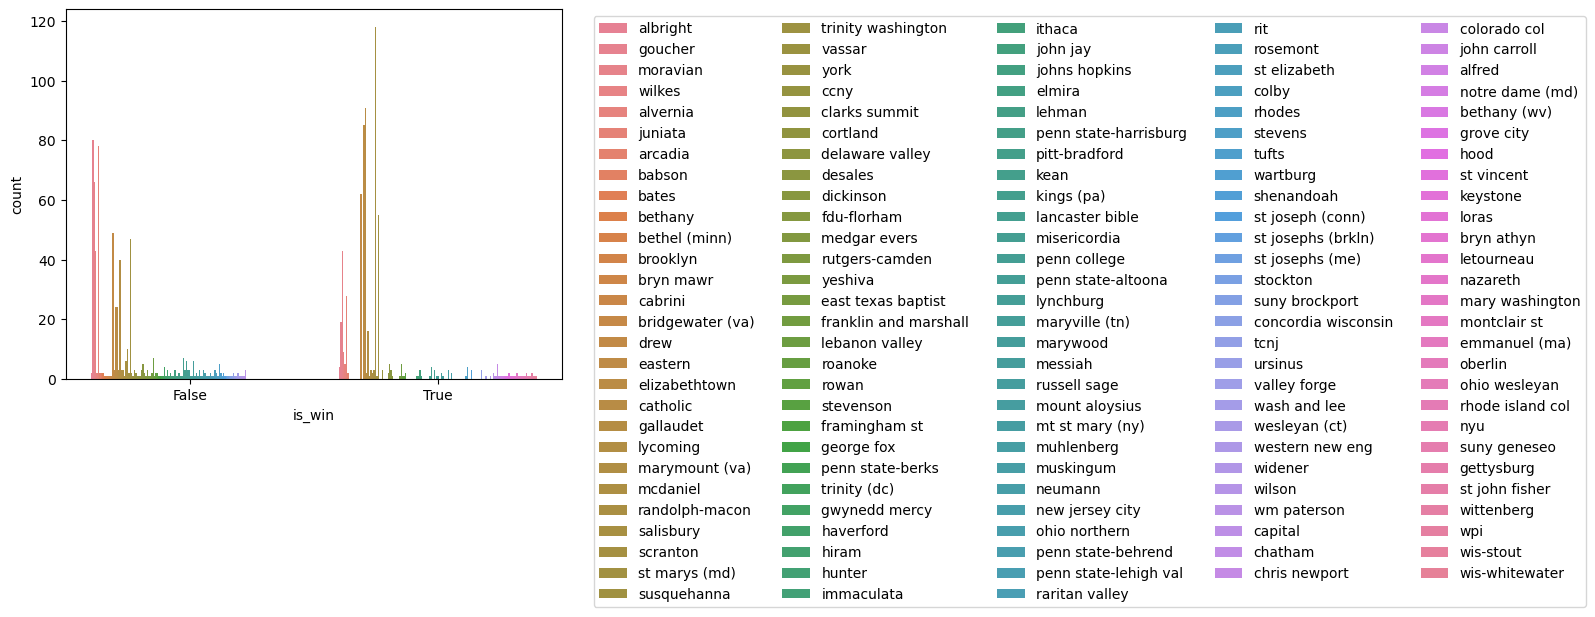

In [20]:
sns.countplot(data=team_stats, x='is_win', hue='Team')

plt.legend(bbox_to_anchor=(1.05, 1), ncol=5)

<Axes: >

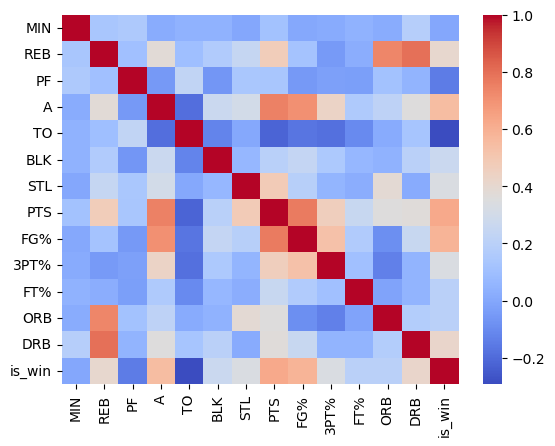

In [21]:
sns.heatmap(data=team_stats.corr(numeric_only=True), cmap='coolwarm')

##### Points, Steals, Attempts, and Rebounds are more than negligibly positively correlated with winning, whereas Turnovers are noticably negatively correlated.

<Axes: >

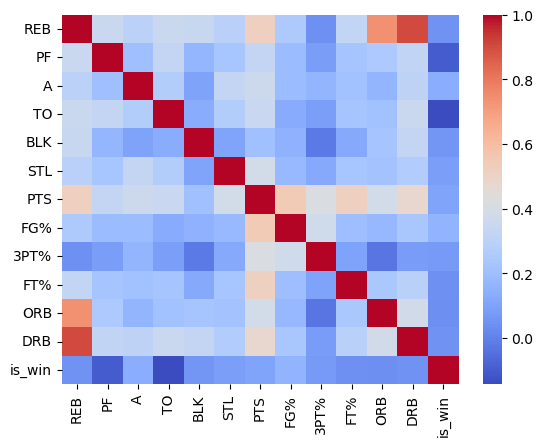

In [22]:
sns.heatmap(data=player_stats.corr(numeric_only=True), cmap='coolwarm')

##### Not too many individual correlations; same correlations though on a smaller degree. Points and steals do not seem to be as impactful. 

Text(0.5, 1.0, 'Distribution of Conference Team game points')

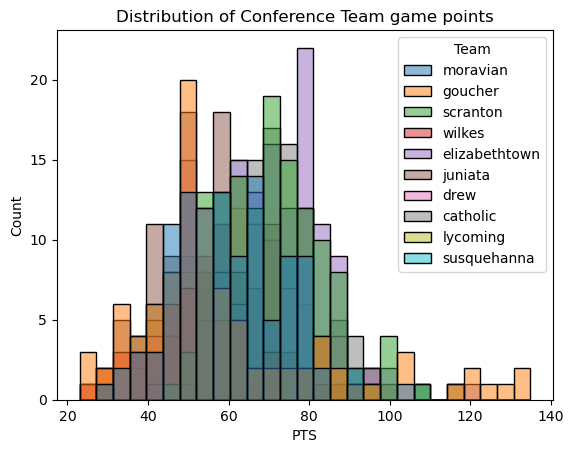

In [23]:
sns.histplot(data=team_stats[team_stats['Team'].apply(lambda team: team in conference_teams)], x='PTS', hue='Team')
plt.title('Distribution of Conference Team game points')

##### The graph shows how different conference teams scored in their games. Most teams scored between 60 and 70 points, which was the most common range. Catholic and Scranton often scored higher, reaching into the 80s and 90s, showing strong performance. Teams like Goucher, Moravian, and Juniata usually had lower scores between 40 and 60 points. While many teams had similar midrange scores, Catholic stood out as one of the most consistent high scorers, showing a clear difference in performance across the conference.

Text(0.5, 1.0, 'Distribution of All Teams game points')

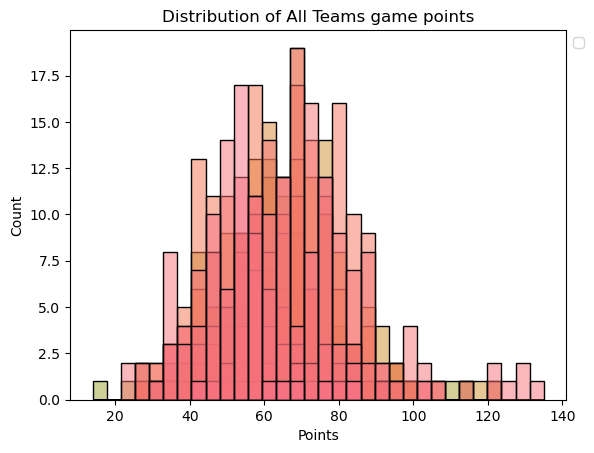

In [24]:
ax = sns.histplot(data=team_stats, x='PTS', hue='Team')
plt.legend(bbox_to_anchor=(1.05, 1), ncol=5)
plt.xlabel('Points')
plt.title('Distribution of All Teams game points')

##### Most teams scored between 50 and 70 points, showing that game performances were fairly even. Only a few teams scored much higher or lower, meaning most games were competitive.

In [25]:
player_stats.columns

Index(['##', 'Player', 'MIN', 'REB', 'PF', 'A', 'TO', 'BLK', 'STL', 'PTS',
       'Team', 'game_id', 'FG%', '3PT%', 'FT%', 'ORB', 'DRB', 'is_win'],
      dtype='object')

In [26]:
team_stats.columns

Index(['game_id', 'Team', 'Home/Away', 'Date', 'Site', 'MIN', 'REB', 'PF', 'A',
       'TO', 'BLK', 'STL', 'PTS', 'FG%', '3PT%', 'FT%', 'ORB', 'DRB',
       'is_win'],
      dtype='object')

In [27]:
conf_teams = team_stats[team_stats['Team'].apply(lambda team: team in conference_teams)]

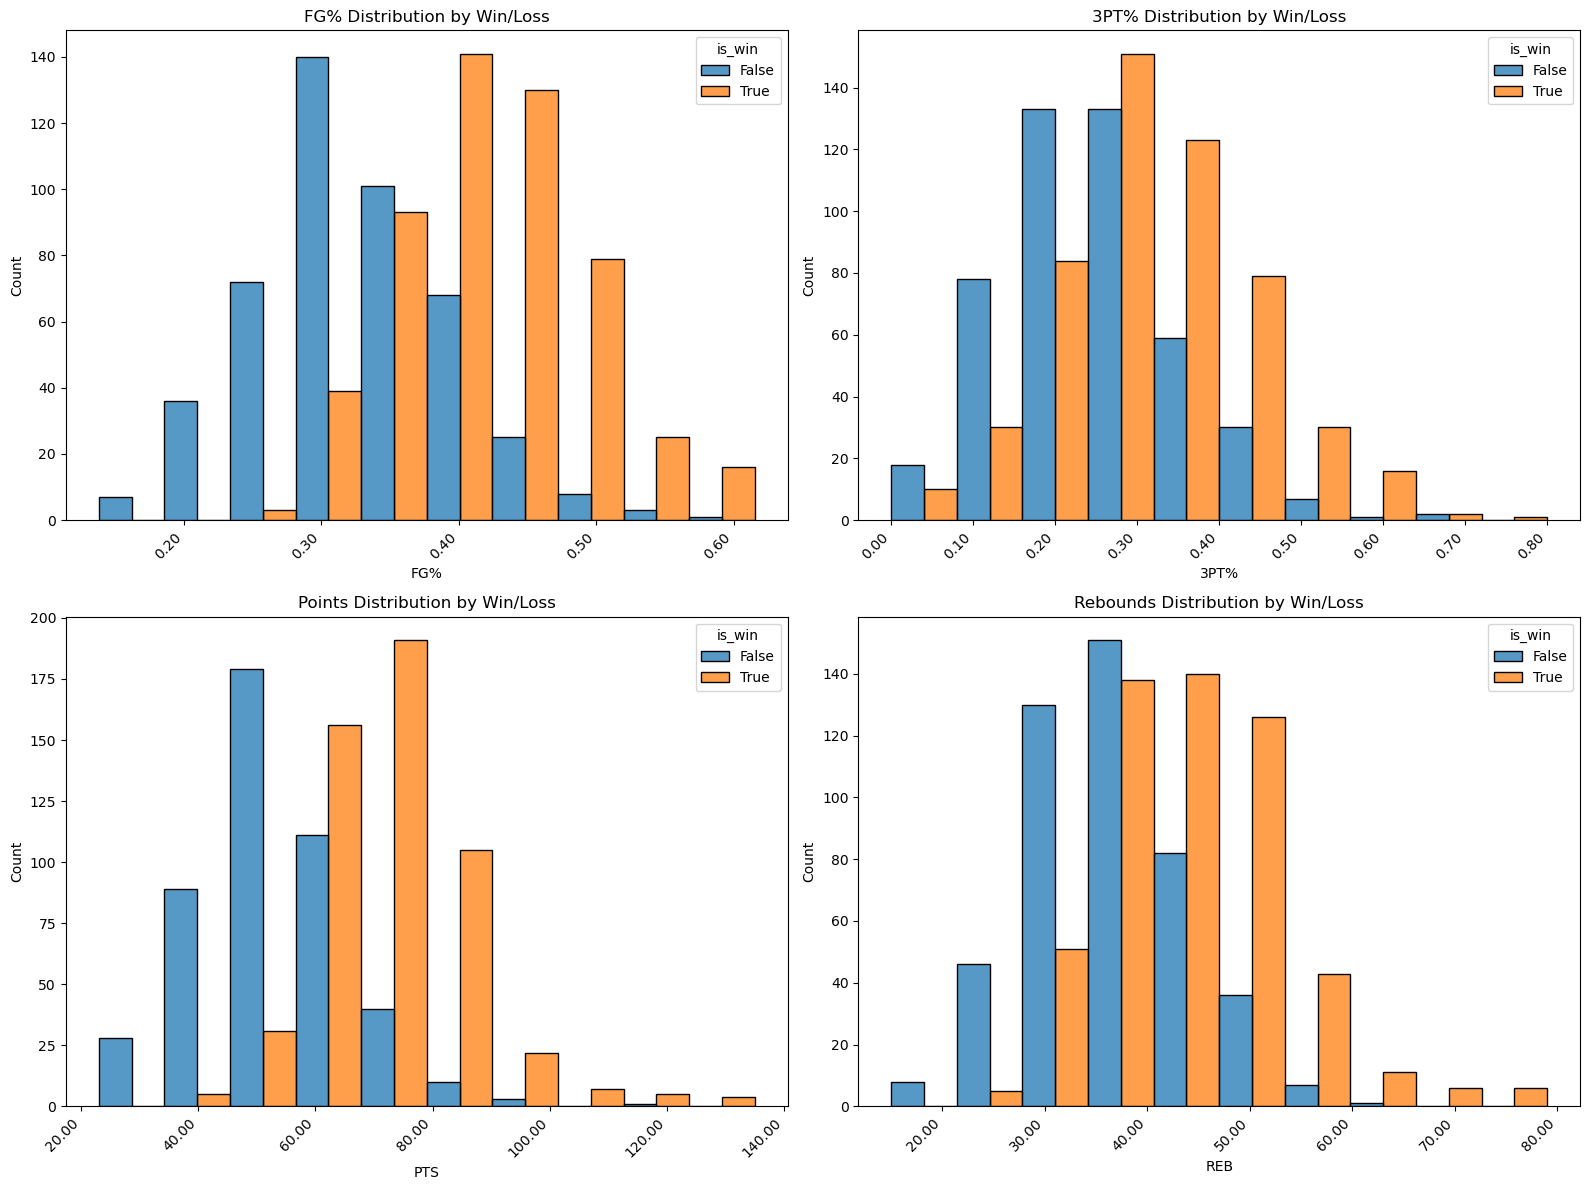

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# FG%
sns.histplot(data=conf_teams, x='FG%', hue='is_win', multiple='dodge', bins=10, ax=axes[0,0])
axes[0,0].set_title('FG% Distribution by Win/Loss')

# 3PT%
sns.histplot(data=conf_teams, x='3PT%', hue='is_win', multiple='dodge', bins=10, ax=axes[0,1])
axes[0,1].set_title('3PT% Distribution by Win/Loss')

# Points
sns.histplot(data=conf_teams, x='PTS', hue='is_win', multiple='dodge', bins=10, ax=axes[1,0])
axes[1,0].set_title('Points Distribution by Win/Loss')

# Rebounds
sns.histplot(data=conf_teams, x='REB', hue='is_win', multiple='dodge', bins=10, ax=axes[1,1])
axes[1,1].set_title('Rebounds Distribution by Win/Loss')

# Rotate x-axis labels for readability
for ax in axes.flatten():
    ax.set_xticklabels([f"{x:.2f}" for x in ax.get_xticks()], rotation=45, ha='right')

plt.tight_layout()
plt.show()

##### This graph easily shows the difference between team that win vs those that lose. It highlights 4 of the most prominent actions that a player on a team can make while on offense

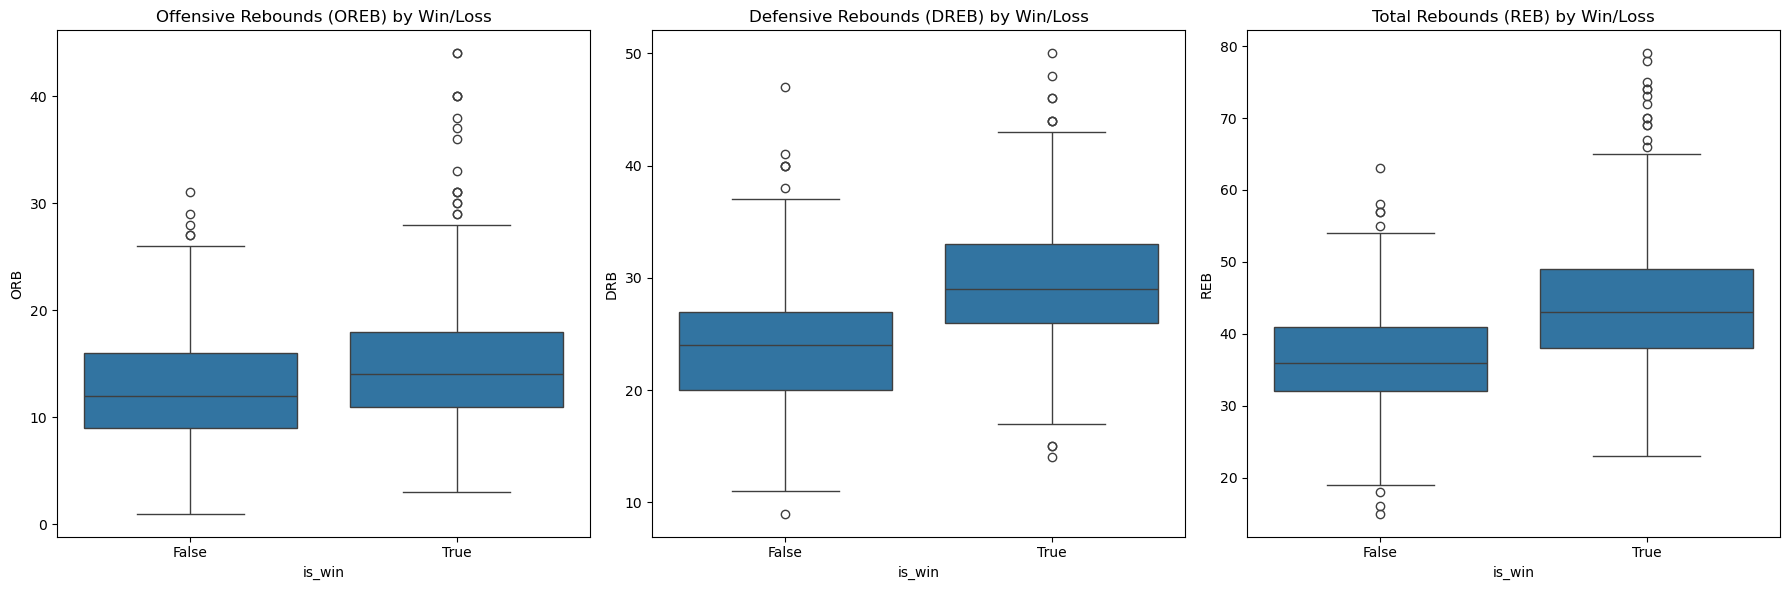

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Offensive Rebounds
sns.boxplot(data=conf_teams, x='is_win', y='ORB', ax=axes[0])
axes[0].set_title('Offensive Rebounds (OREB) by Win/Loss')

# Defensive Rebounds
sns.boxplot(data=conf_teams, x='is_win', y='DRB', ax=axes[1])
axes[1].set_title('Defensive Rebounds (DREB) by Win/Loss')

# Total Rebounds
sns.boxplot(data=conf_teams, x='is_win', y='REB', ax=axes[2])
axes[2].set_title('Total Rebounds (REB) by Win/Loss')

plt.tight_layout()
plt.show()

##### This graph easily shows the difference between team that win vs those that lose. It highlights 3 ways a team can rebound a ball

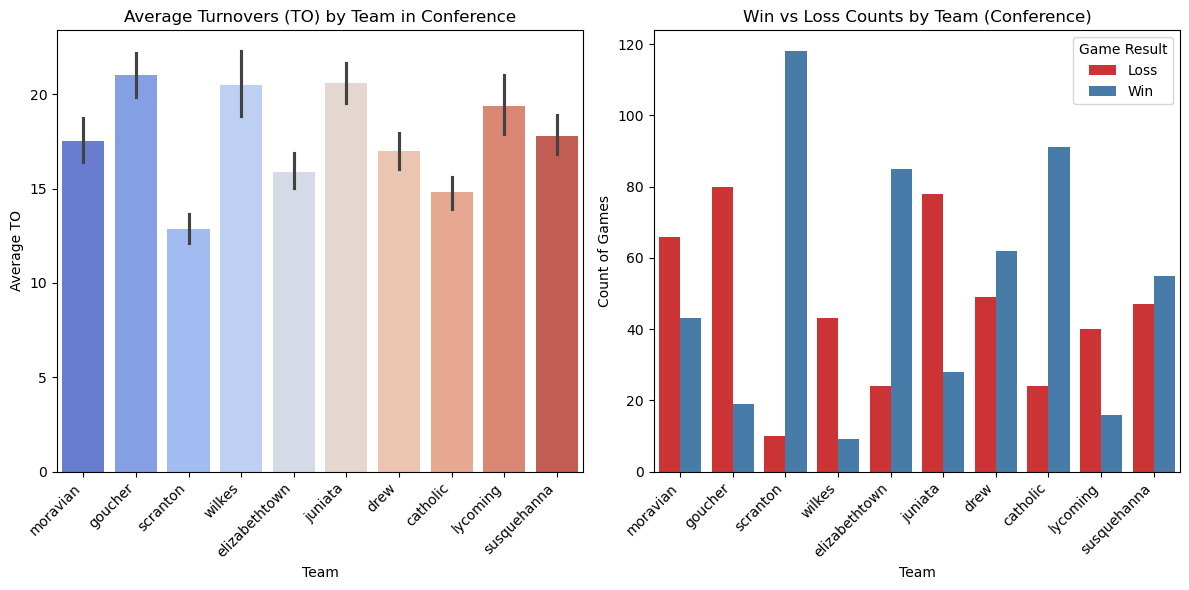

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(data=conf_teams, x='Team', y='TO', palette='coolwarm', ax=ax[0])
ax[0].set_title('Average Turnovers (TO) by Team in Conference')
ax[0].set_ylabel('Average TO')
ax[0].set_xlabel('Team')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

sns.countplot(data=conf_teams, x='Team', hue='is_win', ax=ax[1], palette='Set1')
ax[1].set_title('Win vs Loss Counts by Team (Conference)')
ax[1].set_xlabel('Team')
ax[1].set_ylabel('Count of Games')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[1].legend(title='Game Result', labels=['Loss', 'Win'])
plt.tight_layout()
plt.show()


#### Teams with lower turnovers tend to win more games, reinforcing the importance of limiting mistakes for success.

## Feature Engineering

#### Calculate rolling averages of past games for the team and top player of each team to use to calculate winner of upcoming game.

In [31]:


df = team_stats.copy()

# Train on only conference teams to allow full rolling 5 game window
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Team', 'Date'])
df.reset_index(drop=True, inplace=True)

# Select columns you want to compute rolling averages on
rolling_stats_cols = ['PTS', 'REB', 'A', 'TO', 'STL', 'BLK', 'PF', 'FG%', '3PT%', 'FT%', 'ORB', 'DRB', 'is_win']

# Compute rolling averages (last 5 games, excluding current game)
df_rolling = (
    df.groupby('Team')[rolling_stats_cols]
    .rolling(window=5, min_periods=2, closed="left")
    .mean()
    .reset_index()
)

# Merge back into original df
for col in rolling_stats_cols:
    df[f'{col}_rolling_5'] = df_rolling[col]
df = df.dropna(axis=0)

# Create copies of dataframes for usage
df_team = team_stats[team_stats['Team'].apply(lambda team: team in conference_teams)].copy()
df_player = player_stats[player_stats['Team'].apply(lambda team: team in conference_teams)].copy()
df_team = team_stats.copy()
df_player = player_stats.copy()
df_team_dates = df_team[['game_id', 'Date']].drop_duplicates()
# Join player dataframe by game_id
df_player = df_player.merge(
    df_team_dates,
    on='game_id',
    how='left'
)

# Sort values in player table
df_player['Date'] = pd.to_datetime(df_player['Date'])
df_player = df_player.sort_values(by=['Player', 'Date'])

player_rolling_cols = ['PTS', 'REB', 'A', 'TO', 'STL', 'BLK', 'PF',
                       'FG%', '3PT%', 'FT%', 'ORB', 'DRB']
# Calculate last-5-game rolling averages for individual players
player_rolling = (
    df_player.groupby('Player')[player_rolling_cols]
    .rolling(window=5, min_periods=3, closed="left")    # <= EXCLUDES current game
    .mean()
    .reset_index()
)

# Rename columns to allow for player & team data differentiation
df_player.reset_index(drop=True, inplace=True)
for col in df_player.columns:
    if col not in ['game_id', 'Team', 'Date']:
        df_player.rename(columns={col: f'{col}_player'}, inplace=True)
# Copy over rolling averages to respective player
for col in player_rolling_cols:
    df_player[f'{col}_rolling_5_player_max'] = player_rolling[col]
# Fetch player with max rolling average per game, per team
df_player.dropna(axis=0, inplace=True)
players_max_rollings = df_player.groupby(['game_id','Team','Date']).max()

# Join player rolling averages back to main dataframe by game
df = df.merge(
    players_max_rollings,
    on=['game_id', 'Team', 'Date'],
    how='left'
)


# Split dataframe into two views: one per game per team
team_a = df[df['Home/Away'] == 'home'].copy()
team_b = df[df['Home/Away'] == 'away'].copy()

# Merge home team (A) and away team (B) on game_id
matchups = team_a.merge(
    team_b,
    on=['game_id','Date'],
    suffixes=('_A', '_B')
)

feature_cols_team = [
    'PTS_rolling_5', 'REB_rolling_5', 'A_rolling_5', 'TO_rolling_5', 'STL_rolling_5',
    'BLK_rolling_5', 'PF_rolling_5', 'FG%_rolling_5', '3PT%_rolling_5', 'FT%_rolling_5',
    'ORB_rolling_5', 'DRB_rolling_5', 'is_win_rolling_5'
]
feature_cols_players = [
    'PTS_rolling_5_player_max', 'REB_rolling_5_player_max', 'A_rolling_5_player_max', 'TO_rolling_5_player_max', 'STL_rolling_5_player_max',
    'BLK_rolling_5_player_max', 'PF_rolling_5_player_max', 'FG%_rolling_5_player_max', '3PT%_rolling_5_player_max', 'FT%_rolling_5_player_max',
    'ORB_rolling_5_player_max', 'DRB_rolling_5_player_max'
]

# Retrieve final columns used for prediction
rolling_matchups = matchups[
    ['game_id', 'Date', 'Team_A', 'Team_B', 'is_win_A'] +  # keep winner label
    [f"{c}_A" for c in feature_cols_team] +
    [f"{c}_B" for c in feature_cols_team] +
    [f"{c}_A" for c in feature_cols_players] +
    [f"{c}_B" for c in feature_cols_players]
].copy()

# Relabel the `label` column indicating a win for the home team
rolling_matchups.rename(columns={"is_win_A": "label"}, inplace=True)
rolling_matchups['label'] = rolling_matchups['label'].astype(int)


rolling_matchups.isnull().sum()
rolling_matchups.dropna(axis=0, inplace=True)
display(rolling_matchups.columns)

Index(['game_id', 'Date', 'Team_A', 'Team_B', 'label', 'PTS_rolling_5_A',
       'REB_rolling_5_A', 'A_rolling_5_A', 'TO_rolling_5_A', 'STL_rolling_5_A',
       'BLK_rolling_5_A', 'PF_rolling_5_A', 'FG%_rolling_5_A',
       '3PT%_rolling_5_A', 'FT%_rolling_5_A', 'ORB_rolling_5_A',
       'DRB_rolling_5_A', 'is_win_rolling_5_A', 'PTS_rolling_5_B',
       'REB_rolling_5_B', 'A_rolling_5_B', 'TO_rolling_5_B', 'STL_rolling_5_B',
       'BLK_rolling_5_B', 'PF_rolling_5_B', 'FG%_rolling_5_B',
       '3PT%_rolling_5_B', 'FT%_rolling_5_B', 'ORB_rolling_5_B',
       'DRB_rolling_5_B', 'is_win_rolling_5_B', 'PTS_rolling_5_player_max_A',
       'REB_rolling_5_player_max_A', 'A_rolling_5_player_max_A',
       'TO_rolling_5_player_max_A', 'STL_rolling_5_player_max_A',
       'BLK_rolling_5_player_max_A', 'PF_rolling_5_player_max_A',
       'FG%_rolling_5_player_max_A', '3PT%_rolling_5_player_max_A',
       'FT%_rolling_5_player_max_A', 'ORB_rolling_5_player_max_A',
       'DRB_rolling_5_player_max_

## Data Modeling

In [48]:
X = rolling_matchups.drop(columns=['label', 'game_id', 'Date', 'Team_A', 'Team_B'])
y = rolling_matchups['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1101)
x_cols = list(rolling_matchups.drop(columns=['label', 'game_id', 'Date', 'Team_A', 'Team_B']).columns)
X_train = X_train[x_cols]
X_test = X_test[x_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.metrics import confusion_matrix, classification_report

# Logistic Regression
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(random_state=101)
log.fit(X_train_scaled, y_train)

pred_y_log = log.predict(X_test_scaled)

print(confusion_matrix(y_test, pred_y_log))
print(classification_report(y_test, pred_y_log))

# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

pred_y_knn = knn.predict(X_test_scaled)

print(confusion_matrix(y_test, pred_y_knn))
print(classification_report(y_test, pred_y_knn))

# SVM
from sklearn.svm import SVC

svc = SVC(random_state=101)
svc.fit(X_train_scaled, y_train)
pred_y_svc = svc.predict(X_test_scaled)

print(confusion_matrix(y_test, pred_y_svc))
print(classification_report(y_test, pred_y_svc))


[[36 10]
 [ 8 28]]
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        46
           1       0.74      0.78      0.76        36

    accuracy                           0.78        82
   macro avg       0.78      0.78      0.78        82
weighted avg       0.78      0.78      0.78        82

[[36 10]
 [ 8 28]]
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        46
           1       0.74      0.78      0.76        36

    accuracy                           0.78        82
   macro avg       0.78      0.78      0.78        82
weighted avg       0.78      0.78      0.78        82

[[38  8]
 [ 8 28]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        46
           1       0.78      0.78      0.78        36

    accuracy                           0.80        82
   macro avg       0.80      0.80      0.80        82
weighted avg     

#### Create a higher dimension DataFrame with more rolling averages for more data

In [275]:
X_train_scaled_inc.shape

(257, 122)

In [33]:

df = team_stats.copy()

# Train on only conference teams to allow full rolling 5 game window
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Team', 'Date'])
df.reset_index(drop=True, inplace=True)

# Select columns you want to compute rolling averages on
rolling_stats_cols = ['PTS', 'REB', 'A', 'TO', 'STL', 'BLK', 'PF', 'FG%', '3PT%', 'FT%', 'ORB', 'DRB', 'is_win']

# Compute rolling averages (last 5 games, excluding current game)
df_rolling = (
    df.groupby('Team')[rolling_stats_cols]
    .rolling(window=5, min_periods=2, closed="left")
    .mean()
    .reset_index()
)

# Merge back into original df
for col in rolling_stats_cols:
    df[f'{col}_rolling_5'] = df_rolling[col]
df = df.dropna(axis=0)

# Create copies of dataframes for usage
df_team = team_stats[team_stats['Team'].apply(lambda team: team in conference_teams)].copy()
df_player = player_stats[player_stats['Team'].apply(lambda team: team in conference_teams)].copy()
df_team_dates = df_team[['game_id', 'Date']].drop_duplicates()
# Join player dataframe by game_id
df_player = df_player.merge(
    df_team_dates,
    on='game_id',
    how='left'
)

# Sort values in player table
df_player['Date'] = pd.to_datetime(df_player['Date'])
df_player = df_player.sort_values(by=['Player', 'Date'])

player_rolling_cols = ['PTS', 'REB', 'A', 'TO', 'STL', 'BLK', 'PF',
                       'FG%', '3PT%', 'FT%', 'ORB', 'DRB']
# Calculate last-5-game rolling averages for individual players
player_rolling = (
    df_player.groupby('Player')[player_rolling_cols]
    .rolling(window=5, min_periods=3, closed="left") # Excludes current game
    .mean()
    .reset_index()
)

# Rename columns to allow for player & team data differentiation
df_player.reset_index(drop=True, inplace=True)
for col in df_player.columns:
    if col not in ['game_id', 'Team', 'Date']:
        df_player.rename(columns={col: f'{col}_player'}, inplace=True)
# Copy over rolling averages to respective player
for col in player_rolling_cols:
    df_player[f'{col}_rolling_5_player'] = player_rolling[col]
df_player.dropna(axis=0, inplace=True)

# Custom function to get top 4 values (max and second max)
def top4players(s):
    vals = s.nlargest(4).tolist()
    # Ensure at least 4 values (or fill with NaN if missing)
    return pd.Series(vals + [float('nan')] * (4 - len(vals)), index=['max', 'second_max', 'third_max', 'fourth_max'])
result_player_maxes = (
    df_player.groupby(['game_id','Team','Date'])[[f'{col}_rolling_5_player' for col in player_rolling_cols]]
      .apply(lambda g: g.apply(top4players))
)

# Reorganize all columns into 2D DataFrame
result_player_maxes = result_player_maxes.unstack()
result_player_maxes.columns = [f"{col}_{suffix}" for col, suffix in result_player_maxes.columns]


# Join player rolling averages back to main dataframe by game
df = df.merge(
    result_player_maxes,
    on=['game_id', 'Team', 'Date'],
    how='left'
)


# Split dataframe into two views: one per game per team
team_a = df[df['Home/Away'] == 'home'].copy()
team_b = df[df['Home/Away'] == 'away'].copy()

# Merge home team (A) and away team (B) on game_id
matchups = team_a.merge(
    team_b,
    on=['game_id','Date'],
    suffixes=('_A', '_B')
)

feature_cols_team_inc = [
    'PTS_rolling_5', 'REB_rolling_5', 'A_rolling_5', 'TO_rolling_5', 'STL_rolling_5',
    'BLK_rolling_5', 'PF_rolling_5', 'FG%_rolling_5', '3PT%_rolling_5', 'FT%_rolling_5',
    'ORB_rolling_5', 'DRB_rolling_5', 'is_win_rolling_5'
]
feature_cols_players_inc = [
    'PTS_rolling_5_player_max', 'REB_rolling_5_player_max', 'A_rolling_5_player_max', 'TO_rolling_5_player_max', 'STL_rolling_5_player_max',
    'BLK_rolling_5_player_max', 'PF_rolling_5_player_max', 'FG%_rolling_5_player_max', '3PT%_rolling_5_player_max', 'FT%_rolling_5_player_max',
    'ORB_rolling_5_player_max', 'DRB_rolling_5_player_max',
    'PTS_rolling_5_player_second_max', 'REB_rolling_5_player_second_max', 'A_rolling_5_player_second_max', 'TO_rolling_5_player_second_max', 'STL_rolling_5_player_second_max',
    'BLK_rolling_5_player_second_max', 'PF_rolling_5_player_second_max', 'FG%_rolling_5_player_second_max', '3PT%_rolling_5_player_second_max', 'FT%_rolling_5_player_second_max',
    'ORB_rolling_5_player_second_max', 'DRB_rolling_5_player_second_max',
    'PTS_rolling_5_player_third_max', 'REB_rolling_5_player_third_max', 'A_rolling_5_player_third_max', 'TO_rolling_5_player_third_max', 'STL_rolling_5_player_third_max',
    'BLK_rolling_5_player_third_max', 'PF_rolling_5_player_third_max', 'FG%_rolling_5_player_third_max', '3PT%_rolling_5_player_third_max', 'FT%_rolling_5_player_third_max',
    'ORB_rolling_5_player_third_max', 'DRB_rolling_5_player_third_max',
    'PTS_rolling_5_player_fourth_max', 'REB_rolling_5_player_fourth_max', 'A_rolling_5_player_fourth_max', 'TO_rolling_5_player_fourth_max', 'STL_rolling_5_player_fourth_max',
    'BLK_rolling_5_player_fourth_max', 'PF_rolling_5_player_fourth_max', 'FG%_rolling_5_player_fourth_max', '3PT%_rolling_5_player_fourth_max', 'FT%_rolling_5_player_fourth_max',
    'ORB_rolling_5_player_fourth_max', 'DRB_rolling_5_player_fourth_max',
    
]

# Retrieve final columns used for prediction
rolling_matchups_inc = matchups[
    ['game_id', 'Date', 'Team_A', 'Team_B', 'is_win_A'] +  # keep winner label
    [f"{c}_A" for c in feature_cols_team_inc] +
    [f"{c}_B" for c in feature_cols_team_inc] +
    [f"{c}_A" for c in feature_cols_players_inc] + 
    [f"{c}_B" for c in feature_cols_players_inc]
].copy()

# Relabel the `label` column indicating a win for the home team
rolling_matchups_inc.rename(columns={"is_win_A": "label"}, inplace=True)
rolling_matchups_inc['label'] = rolling_matchups_inc['label'].astype(int)


rolling_matchups_inc.isnull().sum()
rolling_matchups_inc.dropna(axis=0, inplace=True)
display(rolling_matchups_inc.columns)

Index(['game_id', 'Date', 'Team_A', 'Team_B', 'label', 'PTS_rolling_5_A',
       'REB_rolling_5_A', 'A_rolling_5_A', 'TO_rolling_5_A', 'STL_rolling_5_A',
       ...
       'A_rolling_5_player_fourth_max_B', 'TO_rolling_5_player_fourth_max_B',
       'STL_rolling_5_player_fourth_max_B',
       'BLK_rolling_5_player_fourth_max_B', 'PF_rolling_5_player_fourth_max_B',
       'FG%_rolling_5_player_fourth_max_B',
       '3PT%_rolling_5_player_fourth_max_B',
       'FT%_rolling_5_player_fourth_max_B',
       'ORB_rolling_5_player_fourth_max_B',
       'DRB_rolling_5_player_fourth_max_B'],
      dtype='object', length=127)

#### Train & Evaluate models with increased-dimensioned data

In [55]:
X = rolling_matchups_inc.drop(columns=['label', 'game_id', 'Date', 'Team_A', 'Team_B'])
y = rolling_matchups_inc['label']

X_train, X_test, y_train_inc, y_test_inc = train_test_split(X, y, train_size=0.8, random_state=10)
x_cols = list(rolling_matchups_inc.drop(columns=['label', 'game_id', 'Date', 'Team_A', 'Team_B']).columns)
X_train = X_train[x_cols]
X_test = X_test[x_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled_inc = scaler.fit_transform(X_train)
X_test_scaled_inc = scaler.transform(X_test)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_inc = LogisticRegression(random_state=101)
log_inc.fit(X_train_scaled_inc, y_train_inc)
pred_y_log_inc = log_inc.predict(X_test_scaled_inc)

print(confusion_matrix(y_test_inc, pred_y_log_inc))
print(classification_report(y_test_inc, pred_y_log_inc))

# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_inc = KNeighborsClassifier()
knn_inc.fit(X_train_scaled_inc, y_train_inc)
pred_y_knn_inc = knn_inc.predict(X_test_scaled_inc)

print(confusion_matrix(y_test_inc, pred_y_knn_inc))
print(classification_report(y_test_inc, pred_y_knn_inc))

# SVM
from sklearn.svm import SVC

svc_inc = SVC(random_state=101)
svc_inc.fit(X_train_scaled_inc, y_train_inc)
pred_y_svc_inc = svc_inc.predict(X_test_scaled_inc)

print(confusion_matrix(y_test_inc, pred_y_svc_inc))
print(classification_report(y_test_inc, pred_y_svc_inc))


[[28  8]
 [ 5 24]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81        36
           1       0.75      0.83      0.79        29

    accuracy                           0.80        65
   macro avg       0.80      0.80      0.80        65
weighted avg       0.80      0.80      0.80        65

[[29  7]
 [ 6 23]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        36
           1       0.77      0.79      0.78        29

    accuracy                           0.80        65
   macro avg       0.80      0.80      0.80        65
weighted avg       0.80      0.80      0.80        65

[[32  4]
 [ 8 21]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        36
           1       0.84      0.72      0.78        29

    accuracy                           0.82        65
   macro avg       0.82      0.81      0.81        65
weighted avg     

### Hyperparameter Tuning with GridSearch on all Models

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid_log = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs'], 
    'max_iter': [100, 200, 500]
}
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 8, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'leaf_size': [20, 30, 40],
}
param_grid_svc = {
    'C': [0.1, 1, 3, 10, 31, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}
grid_logistic = GridSearchCV(LogisticRegression(random_state=101, n_jobs=-1), param_grid=param_grid_log, refit=True, verbose=1)
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, refit=True, verbose=1, scoring='accuracy')
grid_svc = GridSearchCV(SVC(random_state=101), param_grid=param_grid_svc, refit=True, verbose=1)


In [57]:
grid_logistic.fit(X_train_scaled_inc, y_train_inc)
grid_knn.fit(X_train_scaled_inc, y_train_inc)
grid_svc.fit(X_train_scaled_inc, y_train_inc)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=SVC(random_state=101),
             param_grid={'C': [0.1, 1, 3, 10, 31, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [58]:
print("Logistic Regression")
display(grid_logistic.best_params_)
y_pred_grid_log = grid_logistic.predict(X_test_scaled_inc)
print(confusion_matrix(y_test_inc, y_pred_grid_log))
print(classification_report(y_test_inc, y_pred_grid_log))

print("KNN")
display(grid_knn.best_params_)
y_pred_grid_knn = grid_knn.predict(X_test_scaled_inc)
print(confusion_matrix(y_test_inc, y_pred_grid_knn))
print(classification_report(y_test_inc, y_pred_grid_knn))

print("SVC")
display(grid_svc.best_params_)
y_pred_grid_svc = grid_svc.predict(X_test_scaled_inc)
print(confusion_matrix(y_test_inc, y_pred_grid_svc))
print(classification_report(y_test_inc, y_pred_grid_svc))


Logistic Regression


{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

[[30  6]
 [ 3 26]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        36
           1       0.81      0.90      0.85        29

    accuracy                           0.86        65
   macro avg       0.86      0.86      0.86        65
weighted avg       0.87      0.86      0.86        65

KNN


{'leaf_size': 20,
 'metric': 'manhattan',
 'n_neighbors': 8,
 'weights': 'uniform'}

[[31  5]
 [ 8 21]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        36
           1       0.81      0.72      0.76        29

    accuracy                           0.80        65
   macro avg       0.80      0.79      0.80        65
weighted avg       0.80      0.80      0.80        65

SVC


{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

[[33  3]
 [ 9 20]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        36
           1       0.87      0.69      0.77        29

    accuracy                           0.82        65
   macro avg       0.83      0.80      0.81        65
weighted avg       0.82      0.82      0.81        65



In [59]:
# Function to predict winner of matchup; returns True for home wins, False for Away wins
def predict(model, home_team_name, away_team_name):
    home_stats = pd.DataFrame(df[df['Team']==home_team_name].sort_values(by='Date').iloc[-1]).T
    away_stats = pd.DataFrame(df[df['Team']==away_team_name].sort_values(by='Date').iloc[-1]).T

    home_team_stats = home_stats[feature_cols_team_inc] 
    for col in home_team_stats.columns:
        home_team_stats = home_team_stats.rename(columns={col: f'{col}_A'})
    away_team_stats = home_stats[feature_cols_team_inc] 
    for col in away_team_stats.columns:
        away_team_stats = away_team_stats.rename(columns={col: f'{col}_B'})
    home_player_stats = home_stats[feature_cols_players_inc] 
    for col in home_player_stats.columns:
        home_player_stats = home_player_stats.rename(columns={col: f'{col}_A'})
    away_player_stats = home_stats[feature_cols_players_inc] 
    for col in away_player_stats.columns:
        away_player_stats = away_player_stats.rename(columns={col: f'{col}_B'})

    X_in = pd.concat([home_team_stats, away_team_stats, home_player_stats, away_player_stats], axis=1)
    X_in_scaled = scaler.transform(X_in)

    return model.predict(X_in_scaled) , model.predict_proba(X_in_scaled)

In [60]:
predict(grid_logistic, "susquehanna", "wilkes")

(array([1]), array([[0.3697828, 0.6302172]]))

## Time Series Analysis

#### Determine the best features to analyze

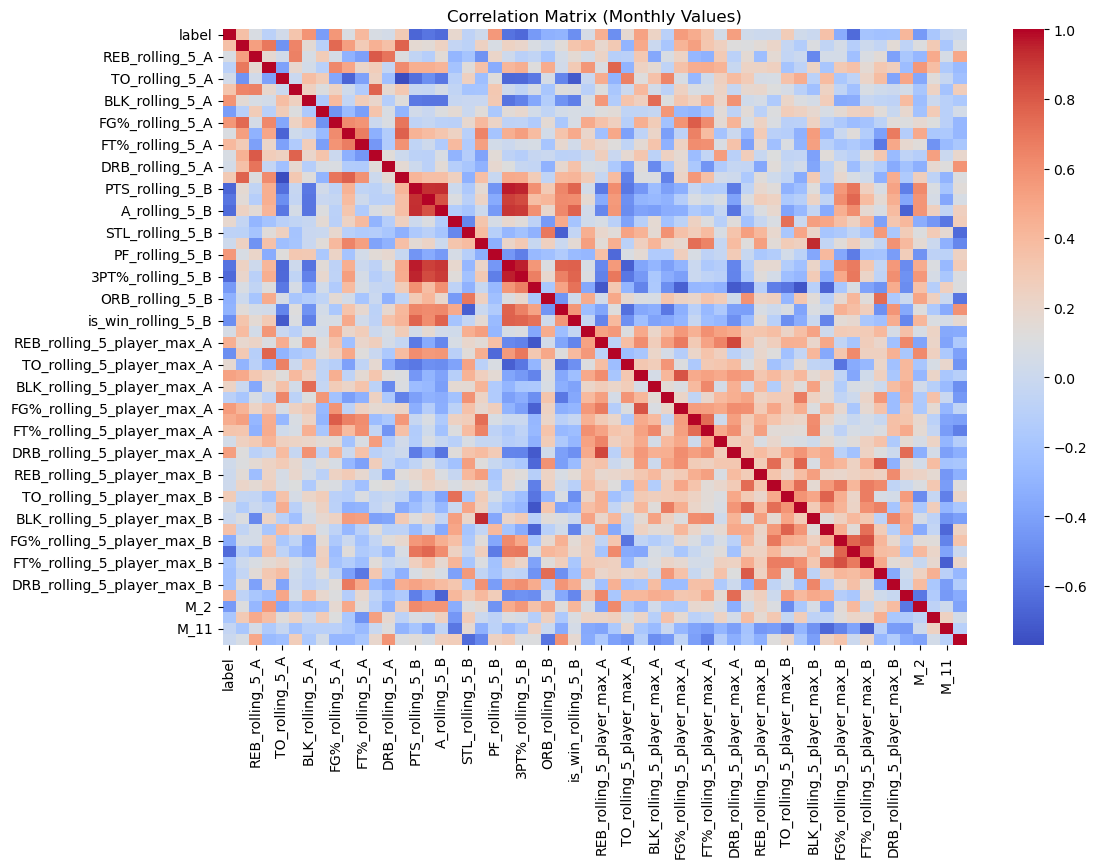

In [379]:
roll_copy = rolling_matchups.copy()
roll_copy['month'] = roll_copy['Date'].dt.month

roll_copy = pd.get_dummies(roll_copy, columns=['month'], prefix='M', drop_first=False)

# Create monthly averages for each feature
monthly_df = roll_copy.groupby(df['Date'].dt.to_period('M')).mean(numeric_only=True)
corr = monthly_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix (Monthly Values)")
plt.show()


In [380]:
# Determine the columns with highest correlation with the months
c = pd.concat([abs(corr[f'M_{i}']).sort_values(ascending=False)[:15] for i in [1,2,3,11,12]], axis=0).index.value_counts()
c.loc[pd.Series(c.index).apply(lambda x: x not in ['M_1', 'M_2', 'M_3', 'M_11', 'M_12']).values]

TO_rolling_5_player_max_B      3
BLK_rolling_5_player_max_B     3
FT%_rolling_5_player_max_A     3
ORB_rolling_5_B                3
PTS_rolling_5_B                2
A_rolling_5_B                  2
BLK_rolling_5_player_max_A     2
is_win_rolling_5_B             2
3PT%_rolling_5_B               2
FG%_rolling_5_B                2
A_rolling_5_player_max_A       2
TO_rolling_5_B                 2
A_rolling_5_A                  2
DRB_rolling_5_player_max_A     2
PF_rolling_5_player_max_A      2
A_rolling_5_player_max_B       2
3PT%_rolling_5_player_max_A    2
REB_rolling_5_A                2
STL_rolling_5_B                2
FT%_rolling_5_B                1
REB_rolling_5_player_max_A     1
TO_rolling_5_A                 1
ORB_rolling_5_A                1
label                          1
PF_rolling_5_B                 1
ORB_rolling_5_player_max_B     1
FT%_rolling_5_A                1
REB_rolling_5_B                1
3PT%_rolling_5_A               1
PTS_rolling_5_A                1
PTS_rollin

In [381]:
# Pick the top few correlated columns
corr_columns = ['TO_rolling_5_player_max_A','TO_rolling_5_player_max_B',
'BLK_rolling_5_player_max_A','BLK_rolling_5_player_max_B',
'FT%_rolling_5_player_max_A','FT%_rolling_5_player_max_B',
'ORB_rolling_5_A','ORB_rolling_5_B',]

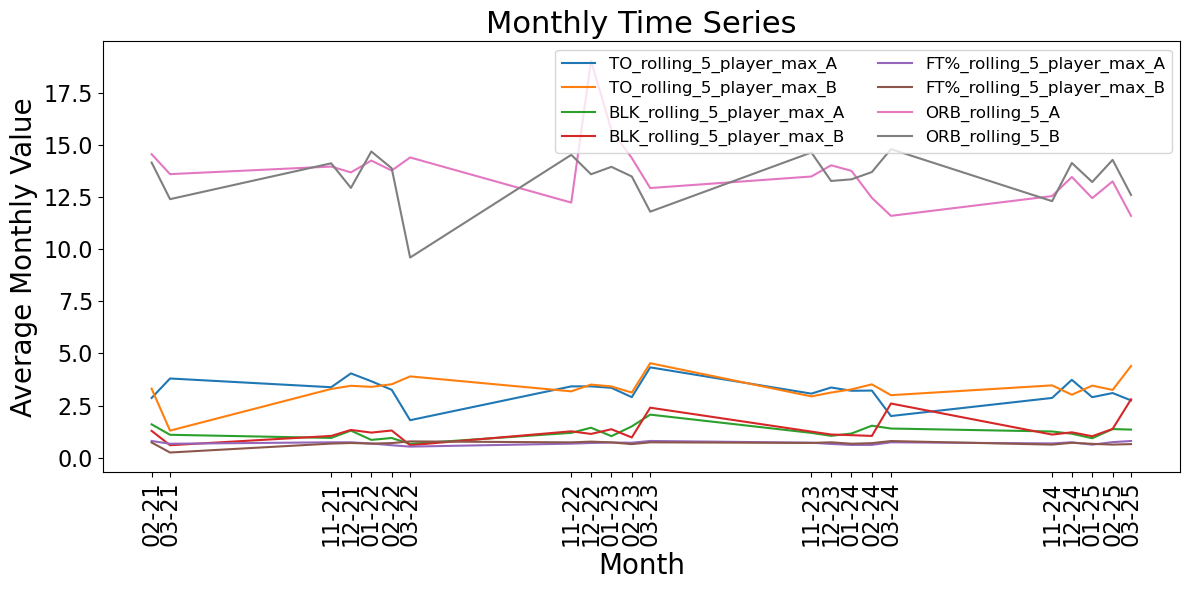

In [382]:
# Plot time series graph
plt.figure(figsize=(12,6))
# plt.plot(monthly_df.index.to_timestamp(), monthly_df[target], label=target)
plt.plot(monthly_df.index.to_timestamp(), monthly_df[corr_columns], label=corr_columns)
plt.legend(fontsize=12, loc='upper right', ncol=2)
plt.title("Monthly Time Series", fontsize=22)
plt.xlabel("Month", fontsize=20)
plt.xticks(monthly_df.index.to_timestamp() , rotation=90, fontsize=16)
plt.xticks(ticks=plt.xticks()[0], labels=monthly_df.index.to_timestamp().strftime('%m-%y'))
plt.ylabel("Average Monthly Value", fontsize=20)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("Monthly_time_series_analysis.png", dpi=400)
plt.show()


### Time series with increased dataset, gridsearched

In [383]:
X = rolling_matchups_inc.copy()
X['Month'] = X['Date'].dt.month
X = pd.get_dummies(X, columns=['Month'], prefix='Month', drop_first=True)
X = X.drop(columns=['label', 'game_id', 'Date', 'Team_A', 'Team_B'])
y = rolling_matchups_inc['label']

X_train, X_test, y_train_inc_time, y_test_inc_time = train_test_split(X, y, train_size=0.8, random_state=10)
x_cols = list(X.columns)
X_train = X_train[x_cols]
X_test = X_test[x_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled_inc_time = scaler.fit_transform(X_train)
X_test_scaled_inc_time = scaler.transform(X_test)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_inc_time = LogisticRegression(random_state=101)
log_inc_time.fit(X_train_scaled_inc_time, y_train_inc_time)
pred_y_log_inc_time = log_inc_time.predict(X_test_scaled_inc_time)

print(confusion_matrix(y_test_inc_time, pred_y_log_inc_time))
print(classification_report(y_test_inc_time, pred_y_log_inc_time))

# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_inc_time = KNeighborsClassifier()
knn_inc_time.fit(X_train_scaled_inc_time, y_train_inc_time)
pred_y_knn_inc_time = knn_inc_time.predict(X_test_scaled_inc_time)

print(confusion_matrix(y_test_inc_time, pred_y_knn_inc_time))
print(classification_report(y_test_inc_time, pred_y_knn_inc_time))

# SVM
from sklearn.svm import SVC

svc_inc_time = SVC(random_state=101)
svc_inc_time.fit(X_train_scaled_inc_time, y_train_inc_time)
pred_y_svc_inc_time = svc_inc_time.predict(X_test_scaled_inc_time)

print(confusion_matrix(y_test_inc_time, pred_y_svc_inc_time))
print(classification_report(y_test_inc_time, pred_y_svc_inc_time))


[[30  6]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        36
           1       0.81      0.86      0.83        29

    accuracy                           0.85        65
   macro avg       0.84      0.85      0.85        65
weighted avg       0.85      0.85      0.85        65

[[30  6]
 [ 7 22]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        36
           1       0.79      0.76      0.77        29

    accuracy                           0.80        65
   macro avg       0.80      0.80      0.80        65
weighted avg       0.80      0.80      0.80        65

[[32  4]
 [ 8 21]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        36
           1       0.84      0.72      0.78        29

    accuracy                           0.82        65
   macro avg       0.82      0.81      0.81        65
weighted avg     

#### Grid search for new best model parameters

In [384]:
from sklearn.model_selection import GridSearchCV

param_grid_log = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs'], 
    'max_iter': [100, 200, 500]
}
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 8, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'leaf_size': [20, 30, 40],
}
param_grid_svc = {
    'C': [0.1, 1, 3, 10, 31, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}
grid_logistic_time = GridSearchCV(LogisticRegression(random_state=101, n_jobs=-1), param_grid=param_grid_log, refit=True, verbose=1)
grid_knn_time = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, refit=True, verbose=1, scoring='accuracy')
grid_svc_time = GridSearchCV(SVC(random_state=101), param_grid=param_grid_svc, refit=True, verbose=1)


In [385]:
grid_logistic_time.fit(X_train_scaled_inc_time, y_train_inc_time)
grid_knn_time.fit(X_train_scaled_inc_time, y_train_inc_time)
grid_svc_time.fit(X_train_scaled_inc_time, y_train_inc_time)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=SVC(random_state=101),
             param_grid={'C': [0.1, 1, 3, 10, 31, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [386]:
print("Logistic Regression")
display(grid_logistic_time.best_params_)
y_pred_grid_log_time = grid_logistic_time.predict(X_test_scaled_inc_time)
print(confusion_matrix(y_test_inc_time, y_pred_grid_log_time))
print(classification_report(y_test_inc_time, y_pred_grid_log_time))

print("KNN")
display(grid_knn_time.best_params_)
y_pred_grid_knn_time = grid_knn_time.predict(X_test_scaled_inc_time)
print(confusion_matrix(y_test_inc_time, y_pred_grid_knn_time))
print(classification_report(y_test_inc_time, y_pred_grid_knn_time))

print("SVC")
display(grid_svc_time.best_params_)
y_pred_grid_svc_time = grid_svc_time.predict(X_test_scaled_inc_time)
print(confusion_matrix(y_test_inc_time, y_pred_grid_svc_time))
print(classification_report(y_test_inc_time, y_pred_grid_svc_time))


Logistic Regression


{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

[[31  5]
 [ 4 25]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.83      0.86      0.85        29

    accuracy                           0.86        65
   macro avg       0.86      0.86      0.86        65
weighted avg       0.86      0.86      0.86        65

KNN


{'leaf_size': 20,
 'metric': 'euclidean',
 'n_neighbors': 9,
 'weights': 'uniform'}

[[27  9]
 [ 8 21]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        36
           1       0.70      0.72      0.71        29

    accuracy                           0.74        65
   macro avg       0.74      0.74      0.74        65
weighted avg       0.74      0.74      0.74        65

SVC


{'C': 3, 'gamma': 0.001, 'kernel': 'rbf'}

[[32  4]
 [ 8 21]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        36
           1       0.84      0.72      0.78        29

    accuracy                           0.82        65
   macro avg       0.82      0.81      0.81        65
weighted avg       0.82      0.82      0.81        65



### Cross validation visualization

In [387]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import cross_val_score

def plot_model_cv_comparison(models, cv=5, scoring='accuracy', figsize=(10, 6)):    
    cv_results = {}
    # Run cross-validation for each model
    for name, model_items in models.items():
        scores = cross_val_score(model_items[0], model_items[1], model_items[2], cv=cv, scoring=scoring)
        cv_results[name] = scores
        print(f"{name} CV scores: {scores}  | Mean = {scores.mean():.4f}")
    
    labels = list(cv_results.keys())
    scores_list = [cv_results[label] for label in labels]
    
    plt.figure(figsize=figsize)
    box = plt.boxplot(scores_list, labels=['GridSearch', 'Time-Series Analysis + GridSearch'] * 3, positions=[1.2,1.8,3.2,3.8,5.2,5.8], patch_artist=True, medianprops={'linewidth': 4})
    
    colors = ['blue', 'green']
    for patch, color in zip(box['boxes'], colors * 3):
        patch.set_facecolor(color)
    
    plt.title("Cross-Validation Accuracy Comparison", fontsize=20)
    plt.ylabel("Accuracy", fontsize=18)
    plt.xlabel("Model Type", fontsize=18)
    plt.yticks(fontsize=16)
    plt.xticks(ticks=[1.5,3.5,5.5], labels=['Logit','KNN','SVC'], fontsize=16)
    legend_handles = [Patch(facecolor='blue', label='GridSearch'), Patch(facecolor='green', label='TS + GridSearch')]
    plt.legend(handles=legend_handles, title="Method", fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    plt.savefig("GS_vs_GS-TS_CV_results.png", dpi=400)
    plt.show()


LR GS CV scores: [0.30769231 0.84615385 0.84615385 0.76923077 0.76923077 1.
 0.84615385 0.61538462 1.         0.76923077 1.         0.76923077
 1.         0.69230769 0.76923077 0.84615385 0.84615385 0.91666667
 0.75       0.75      ]  | Mean = 0.8054
LR GS TS CV scores: [0.30769231 0.84615385 0.84615385 0.76923077 0.76923077 1.
 0.84615385 0.61538462 1.         0.84615385 1.         0.76923077
 1.         0.69230769 0.76923077 0.84615385 0.84615385 0.91666667
 0.75       0.75      ]  | Mean = 0.8093
KNN GS CV scores: [0.38461538 0.76923077 0.61538462 0.84615385 0.69230769 0.92307692
 0.84615385 0.61538462 0.92307692 0.92307692 0.84615385 0.92307692
 0.92307692 0.69230769 0.76923077 0.84615385 0.76923077 0.91666667
 0.83333333 0.75      ]  | Mean = 0.7904
KNN GS TS CV scores: [0.38461538 0.84615385 0.76923077 0.76923077 0.69230769 1.
 0.84615385 0.61538462 0.84615385 0.84615385 0.84615385 0.84615385
 0.92307692 0.84615385 0.76923077 0.84615385 0.76923077 0.83333333
 0.83333333 0.75     

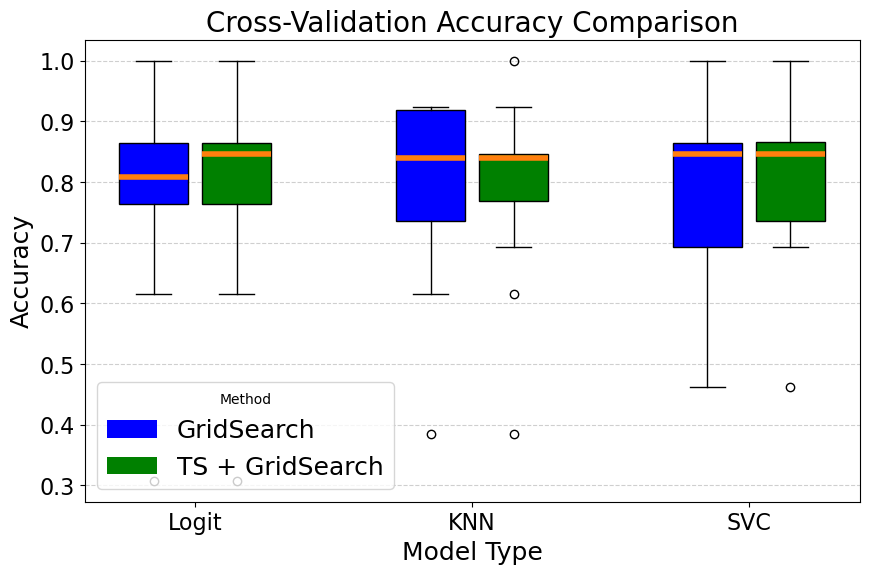

In [388]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    "LR GS": [LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='liblinear', random_state=101), X_train_scaled_inc, y_train_inc],
    "LR GS TS": [LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='liblinear', random_state=101), X_train_scaled_inc_time, y_train_inc_time],
    
    
    "KNN GS": [KNeighborsClassifier(leaf_size=20, metric='manhattan', n_neighbors=8, weights='uniform'), X_train_scaled_inc, y_train_inc],
    "KNN GS TS": [KNeighborsClassifier(leaf_size=20, metric='manhattan', n_neighbors=8, weights='uniform'), X_train_scaled_inc_time, y_train_inc_time],
    
    
    "SVC GS": [SVC(C=1, gamma=0.01, kernel='rbf', random_state=101), X_train_scaled_inc, y_train_inc],
    "SVC GS TS": [SVC(C=1, gamma=0.01, kernel='rbf', random_state=101), X_train_scaled_inc_time, y_train_inc_time],
    
}

# Plot comparison
plot_model_cv_comparison(models, cv=20)
